<a href="https://colab.research.google.com/github/thisisindrajit/Athena/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

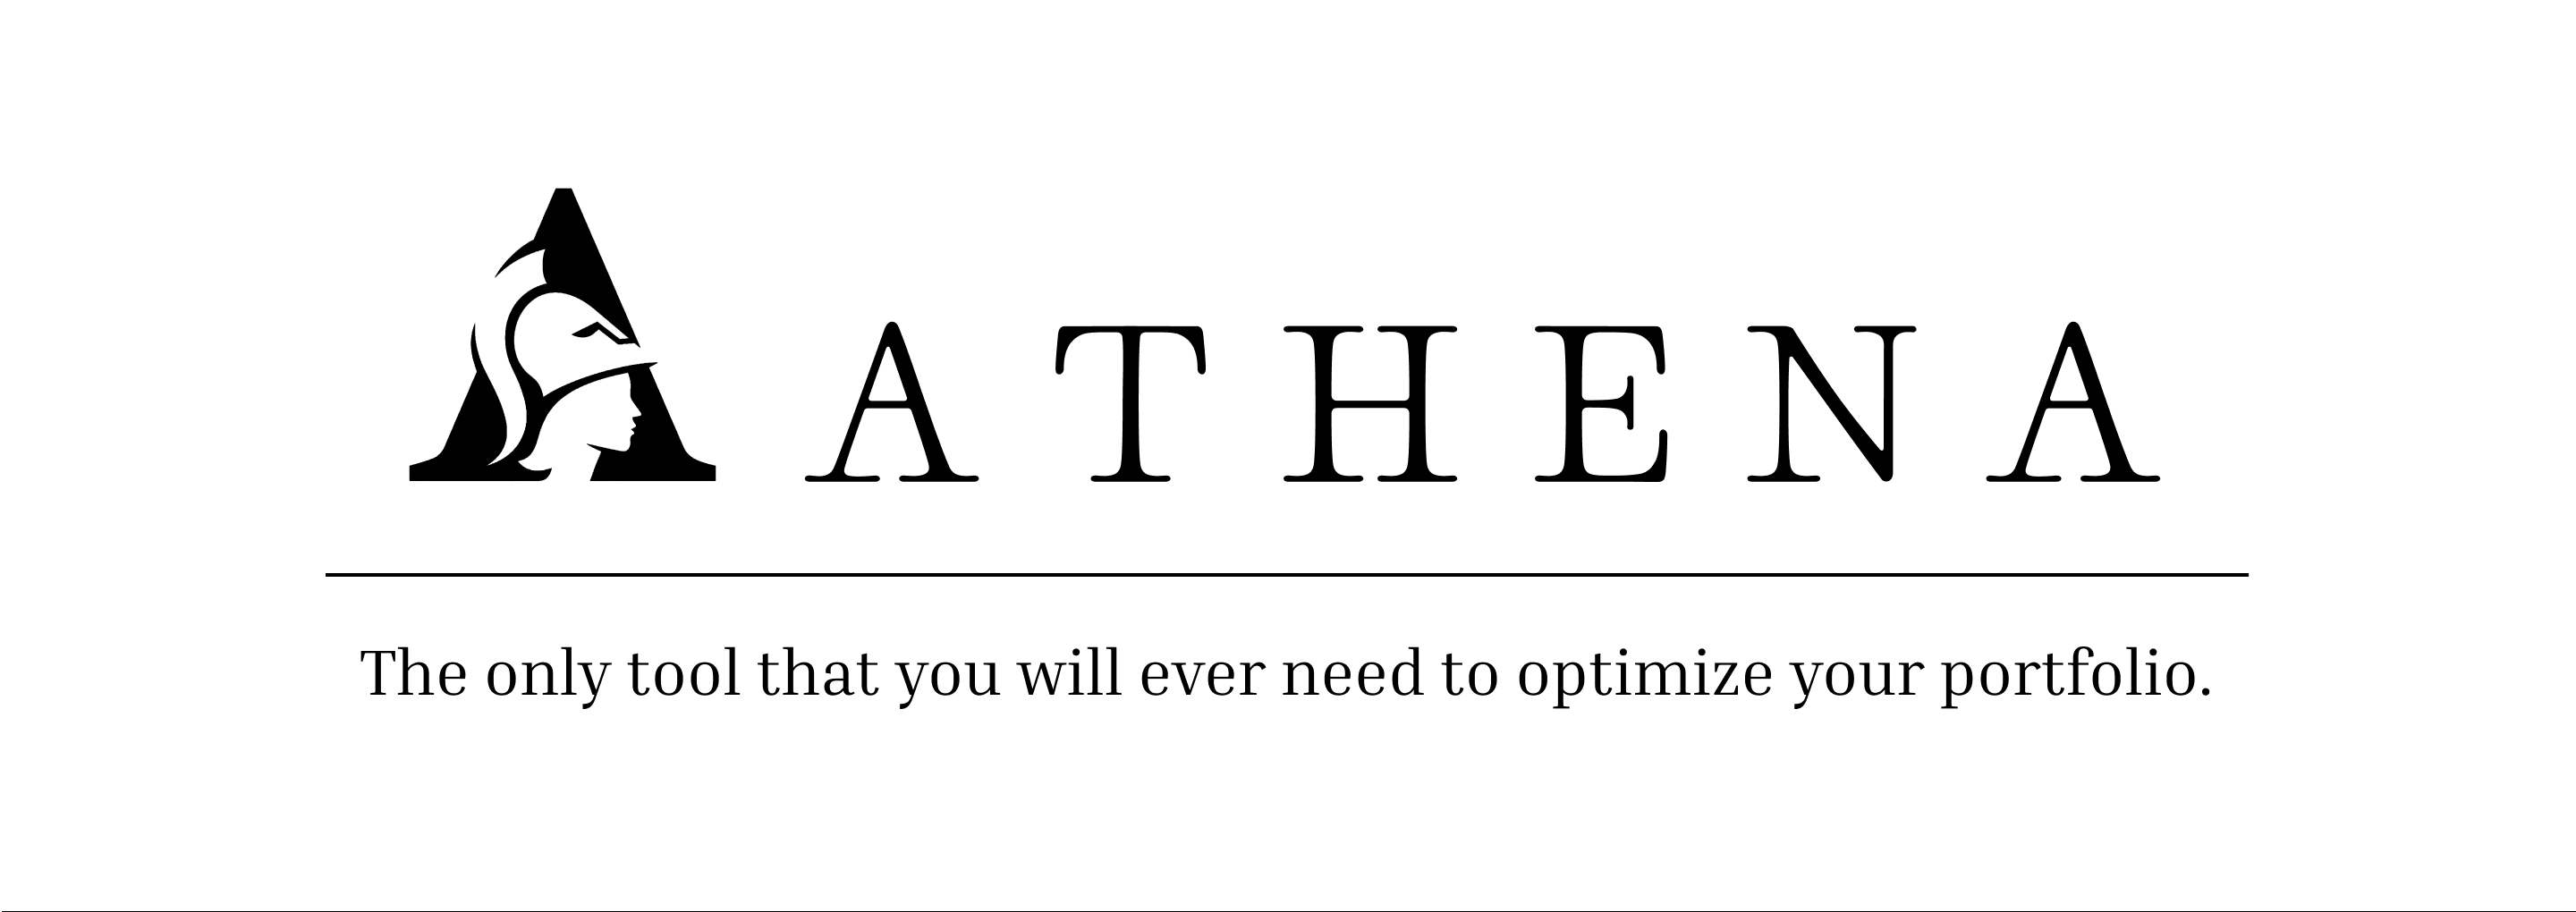

# Athena - Portfolio Optimization using Machine Learning

Athena uses a novel approach to portfolio optimization. It combines both deep learning and statistics along with asset fundamentals analysis to generate a robust portfolio with maximal returns and minimal risk. 

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [1]:
!pip install yfinance
!pip install PyPortfolioOpt
!pip install Riskfolio-Lib
!pip install ffn

In [2]:
import yfinance as yf
import ffn
import riskfolio as rp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import scipy
import pandas as pd
# from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("-----------------------------")
print(f'Tensorflow version: {tf.__version__}')
# print(f'Matplotlib version: {matplotlib. __version__}')
print("All neccessary imports done!")

-----------------------------
Tensorflow version: 2.8.0
All neccessary imports done!


## Variables

**Sample Portfolio 1 [Random selection]**

1. Asian Paints - ASIANPAINT.NS
1. Reliance - RELIANCE.NS
1. Pidilite Industries - PIDILITIND.NS
1. Lupin - LUPIN.NS
1. Indian Oil Corporation - IOC.NS

tickers = ["ASIANPAINT.NS", "RELIANCE.NS", "PIDILITIND.NS", "LUPIN.NS", "IOC.NS"]

---

**Sample Portfolio 2 [Selected based on popularity and market cap]**

1. Adani Ports - ADANIPORTS.NS
1. Asian Paints - ASIANPAINT.NS
1. Axis Bank - AXISBANK.NS
1. ICICI - ICICIBANK.NS
1. Cipla - CIPLA.NS
1. Infosys -  INFY.NS
1. Lupin - LUPIN.NS
1. Dr Reddys Labs - DRREDDY.NS
1. Coal India - COALINDIA.NS
1. Airtel - BHARTIARTL.NS
1. Deepak Nitrite - DEEPAKNTR.NS
1. Expleo Solutions - EXPLEOSOL.NS

tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "ICICIBANK.NS", "CIPLA.NS", "INFY.NS", "LUPIN.NS", "DRREDDY.NS", "COALINDIA.NS", "BHARTIARTL.NS", "DEEPAKNTR.NS", "EXPLEOSOL.NS"]

---

**Sample Portfolio 3 [Selected based on financial news sites suggestions without any fundamental analysis]** 

1. Coforge - COFORGE.NS
1. State bank of India - SBIN.NS
1. Blue star - BLUESTARCO.NS
1. Zen Technologies - ZENTEC.NS
1. Cummins India - CUMMINSIND.NS
1. Trent - TRENT.NS
1. Tata Power - TATAPOWER.NS
1. Vardhman Textiles - VTL.NS
1. Birlasoft - BSOFT.NS
1. APL Apollo Tubes - APLAPOLLO.NS
1. Dhampur Sugar Mills - DHAMPURSUG.NS

tickers = ["COFORGE.NS", "SBIN.NS", "BLUESTARCO.NS", "ZENTEC.NS", "CUMMINSIND.NS", "TRENT.NS", "TATAPOWER.NS", "VTL.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS"]

In [3]:
tickers = ["COFORGE.NS", "SBIN.NS", "BLUESTARCO.NS", "ZENTEC.NS", "CUMMINSIND.NS", 
           "TRENT.NS", "TATAPOWER.NS", "VTL.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS"]
# sorting tickers
tickers.sort()

time_steps = 100 # the lookback period
features = 1 # We use only the close price
min_prev_days = 150
port_len = len(tickers) # length of portfolio
max_port_len = 15 # maximum length of portfolio that is allowed

## Getting data from API (YFinance)

Reference - https://pypi.org/project/yfinance/

In [4]:
def get_data(tickers, getInfo=True, period="5y"):

  if port_len > max_port_len:
    print(f'Only {max_port_len} number of assets allowed in portfolio!')
    return None
  
  # download data of ticker symbol
  data = yf.download(tickers, period=period)
  
  if(getInfo):
    info = []

    for ticker in tickers: 
      info.append(yf.Ticker(ticker).info)

  # check whether if any ticker symbol has less than min_prev_days days of data
  for i in range(port_len):
    cur_ticker_count = data.iloc[:, i].count()

    if cur_ticker_count < min_prev_days:
      print(f'{tickers[i]} has less than {min_prev_days} days of historical price data. Please consider removing the asset or adding some other asset.')
      return None
    
  # remove open, high, low, volume, adj close columns
  data = data.drop("Open", axis = 1)
  data = data.drop("High", axis = 1)
  data = data.drop("Low", axis = 1)
  data = data.drop("Volume", axis = 1)
  data = data.drop("Adj Close", axis = 1)

  if getInfo:
    return data, info
  else:
    return data

In [72]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

# df, info = get_data(tickers)
df = get_data(tickers, getInfo=False, period="5y")
extra_info_tickers = yf.Tickers(tickers)

[*********************100%***********************]  11 of 11 completed


In [9]:
df = df.dropna()
df = df["Close"]
df

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-04-07,120.040001,660.549988,80.905396,442.799988,966.849976,216.949997,289.450012,87.500000,267.750000,266.869995,67.550003
2017-04-10,120.459999,669.900024,80.221596,428.950012,979.250000,213.100006,289.350006,87.050003,271.100006,266.209991,66.599998
2017-04-11,121.605003,671.000000,79.817535,426.450012,980.950012,213.750000,294.500000,85.449997,269.350006,260.559998,66.650002
2017-04-12,121.940002,666.700012,81.464867,426.600006,986.250000,225.949997,290.149994,85.550003,265.350006,261.290009,66.400002
2017-04-13,121.199997,670.099976,80.252678,426.299988,978.349976,221.649994,291.549988,84.699997,269.450012,262.670013,66.300003
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,941.349976,1091.750000,466.600006,4414.850098,1136.699951,538.299988,508.200012,245.449997,1268.449951,436.149994,201.649994
2022-04-04,943.299988,1098.699951,471.850006,4511.600098,1128.250000,560.849976,512.400024,251.949997,1294.650024,455.350006,207.250000
2022-04-05,993.950012,1132.300049,489.649994,4557.600098,1126.849976,557.000000,509.399994,273.600006,1319.199951,459.200012,205.199997


## Converting company information to DataFrame

In [ ]:
# Information of the company of first ticker symbol
infodf0 = pd.DataFrame.from_dict(info[0],orient='index')
infodf0 = infodf0.reset_index()
infodf0

## Visualizing the data

In [ ]:
# Pandas has inbuilt support for matplotlib, so we can use plot function directly

df.plot(label = tickers, figsize = (15,7))

## Geting information like balance sheet, cashflow etc. from YFinance API

### Balance sheet

In [44]:
extra_info_tickers.tickers[tickers[8]].balance_sheet

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Intangible Assets,1.756000e+08,2.025000e+08,2.004000e+08,1.975000e+08
Capital Surplus,1.924300e+10,1.924300e+10,9.768200e+09,9.768200e+09
Total Liab,3.366210e+10,3.039320e+10,9.151500e+09,7.397100e+09
Total Stockholder Equity,2.313030e+10,2.387770e+10,1.646510e+10,1.595370e+10
Minority Interest,4.449000e+08,7.959000e+08,-2.900000e+07,7.800000e+06
Other Current Liab,6.182000e+08,5.746000e+08,9.553000e+08,8.618000e+08
Total Assets,5.723730e+10,5.506680e+10,2.558760e+10,2.335860e+10
Common Stock,3.555000e+08,3.555000e+08,3.323000e+08,3.323000e+08
Other Current Assets,7.879000e+08,6.131000e+08,1.331900e+09,1.157800e+09
Retained Earnings,-2.191200e+09,-3.714000e+08,1.684700e+09,1.238500e+09


### Cashflow

In [46]:
extra_info_tickers.tickers[tickers[8]].cashflow

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Investments,9.496000e+08,-6.793400e+09,1.400700e+09,8.548000e+08
Change To Liabilities,-1.081000e+08,2.632000e+08,4.936000e+08,4.282000e+08
Total Cashflows From Investing Activities,1.565000e+08,-8.155700e+09,-3.704000e+08,-4.030000e+07
Net Borrowings,-8.724000e+08,-1.773200e+09,1.060600e+09,1.000300e+09
Total Cash From Financing Activities,-3.719200e+09,4.519400e+09,3.747000e+08,-7.431000e+08
Change To Operating Activities,-2.349000e+08,-1.488000e+08,-2.085000e+08,-1.333000e+08
Net Income,-1.461700e+09,1.228500e+09,9.696000e+08,8.697000e+08
Change In Cash,1.963000e+08,4.540000e+07,2.142000e+08,-1.470000e+07
Total Cash From Operating Activities,3.738400e+09,3.611600e+09,2.098000e+08,7.686000e+08
Depreciation,2.532500e+09,2.430800e+09,4.793000e+08,4.276000e+08


### Financials

In [47]:
extra_info_tickers.tickers[tickers[8]].financials

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Research Development,None,None,None,None
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,-2048200000.0,1649900000.0,1684500000.0,1466600000.0
Minority Interest,444900000.0,795900000.0,-29000000.0,7800000.0
Net Income,-1461700000.0,1228500000.0,969600000.0,869700000.0
Selling General Administrative,5359500000.0,6154400000.0,6519400000.0,5430900000.0
Gross Profit,9779500000.0,15223100000.0,12321800000.0,10468300000.0
Ebit,-827200000.0,2945900000.0,1867300000.0,1723900000.0
Operating Income,-827200000.0,2945900000.0,1867300000.0,1723900000.0
Other Operating Expenses,2674200000.0,3650400000.0,3418400000.0,2858200000.0


# Using FFN library for performance evaluation of different assets


### Total returns

In [26]:
for i in range(port_len):
  print(f'Total return of {tickers[i]} - {round(ffn.core.calc_total_return(df[tickers[i]]) * 100, 2)}%')

Total return of APLAPOLLO.NS - 728.56%
Total return of BLUESTARCO.NS - 74.91%
Total return of BSOFT.NS - 499.16%
Total return of COFORGE.NS - 906.72%
Total return of CUMMINSIND.NS - 14.67%
Total return of DHAMPURSUG.NS - 163.19%
Total return of SBIN.NS - 76.75%
Total return of TATAPOWER.NS - 238.11%
Total return of TRENT.NS - 397.27%
Total return of VTL.NS - 66.92%
Total return of ZENTEC.NS - 217.32%


### CAGR (Compound Annual Growth Rate)

In [28]:
for i in range(port_len):
  print(f'CAGR of {tickers[i]} - {round(ffn.core.calc_cagr(df[tickers[i]]) * 100, 2)}%')

CAGR of APLAPOLLO.NS - 52.65%
CAGR of BLUESTARCO.NS - 11.83%
CAGR of BSOFT.NS - 43.06%
CAGR of COFORGE.NS - 58.71%
CAGR of CUMMINSIND.NS - 2.78%
CAGR of DHAMPURSUG.NS - 21.36%
CAGR of SBIN.NS - 12.07%
CAGR of TATAPOWER.NS - 27.59%
CAGR of TRENT.NS - 37.83%
CAGR of VTL.NS - 10.79%
CAGR of ZENTEC.NS - 25.98%


# Deep Learning model for future price prediction

## Preprocessing

In [ ]:
# shifting is done here to ensure that the next day's price is predicted on the given day
df_shift = df.shift(-1)

label = df_shift

print(label)

            ASIANPAINT.NS      IOC.NS     LUPIN.NS  PIDILITIND.NS  RELIANCE.NS
Date                                                                          
2017-03-23    1064.250000  186.350006  1487.800049     688.250000   637.333740
2017-03-24    1042.900024  185.449997  1457.750000     682.900024   619.676086
2017-03-27    1057.849976  184.524994  1455.699951     696.500000   617.026184
2017-03-28    1068.099976  185.074997  1454.349976     689.099976   622.425049
2017-03-29    1070.099976  188.399994  1446.949951     690.950012   629.359314
...                   ...         ...          ...            ...          ...
2022-03-16    3136.600098  121.349998   765.349976    2510.399902  2481.699951
2022-03-17    3045.750000  118.000000   755.150024    2485.250000  2467.399902
2022-03-21    3051.149902  120.650002   757.250000    2450.350098  2531.149902
2022-03-22    3007.300049  121.199997   752.500000    2421.899902  2542.000000
2022-03-23            NaN         NaN          NaN  

In [ ]:
# adjusting the shape of both df and label (since label contains NaN as the last value)

df.drop(df.index[len(df)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

In [ ]:
df

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-15,2987.149902,119.000000,737.950012,2370.550049,2363.449951
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951


In [ ]:
label

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-24,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-27,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-28,1068.099976,185.074997,1454.349976,689.099976,622.425049
2017-03-29,1070.099976,188.399994,1446.949951,690.950012,629.359314
...,...,...,...,...,...
2022-03-15,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-16,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-17,3045.750000,118.000000,755.150024,2485.250000,2467.399902


#### For portfolio [not important]

In [ ]:
df["ASIANPAINT.NS"].values.reshape(-1,1)

array([[1061.59997559],
       [1064.25      ],
       [1042.90002441],
       ...,
       [2987.14990234],
       [3042.        ],
       [3136.60009766]])

In [ ]:
x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))
X = []
Y = []

for t in tickers:
  scaled_t = x_scale.fit_transform(df[t].values.reshape(-1,1))
  scaled_label = y_scale.fit_transform(label[t].values.reshape(-1,1))
  
  X.append(scaled_t)
  Y.append(scaled_label)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(5, 1233, 1)
(5, 1233, 1)


#### For single asset and portfolio

In [ ]:
# conversion to numpy array

x, y = df.values, label.values

In [ ]:
# Scaling to normalize the data. MinMaxScaler scales all the data to be in the region of 0 and 1.

x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))

In [ ]:
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,port_len))

print(X.shape)
print(Y.shape)

print(X[0])
print(Y[time_steps])

(1235, 5)
(1235, 5)
[0.00834041 0.74999993 1.         0.0053002  0.0064524 ]
[0.03925707 0.9122272  0.41529208 0.06711196 0.07720612]


## Splitting train/test data and adding timesteps [Best Method]

### For portfolio [not important]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(len(X)):
  X_train, X_test, y_train, y_test = train_test_split(X[i], Y[i], test_size=0.4, shuffle=False)
  X_train_new.append(X_train)
  X_test_new.append(X_test)
  y_train_new.append(y_train)
  y_test_new.append(y_test)

X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(5, 739, 1)
(5, 739, 1)
(5, 494, 1)
(5, 494, 1)


### For single asset and portfolio


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, shuffle=False)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(741, 5)
(741, 5)
(494, 5)
(494, 5)


#### Adding timesteps [Best Method]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(time_steps, len(X_train)):
  X_train_new.append(X_train[i-time_steps:i, :])
  y_train_new.append(y_train[i-1])
  


for i in range(time_steps, len(X_test)):
  X_test_new.append(X_test[i-time_steps:i, :])
  y_test_new.append(y_test[i-1])

#### Converting train and test to numpy arrays and reshaping

In [ ]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(641, 100, 5)
(641, 5)
(394, 100, 5)
(394, 5)


In [ ]:
y_train_new[0]

array([0.03726561, 0.90885743, 0.43189316, 0.06549044, 0.07526218])

In [ ]:
X_train_new = X_train_new.reshape(-1,time_steps,port_len)
X_test_new = X_test_new.reshape(-1,time_steps,port_len)

## Using timesteps (Method 2) [not important]

In [ ]:
scale = MinMaxScaler(feature_range=(0,1))

df = scale.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# Training data is 60% of the whole data. The rest is test data
training_size=int(len(df)*0.6)
test_size=len(df)-training_size

train_data,test_data=df[0:training_size,:],df[training_size:len(df), :1]

In [ ]:
def create_dataset(dataset, time_step):
  dataX, dataY = [], []

  for i in range(len(dataset)-time_step-1):

    # a = dataset[i:(i+time_step), :]
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    # dataY.append(dataset[i + time_step, 3])
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(641, 100)
(394, 100)
(641,)
(394,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print(X_train.shape)
print(X_test.shape)

(641, 100, 1)
(394, 100, 1)


## Deep learning model (GRU)

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=256))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(port_len))

gru_model.compile(loss='mse', optimizer='adam')

In [ ]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 512)          795648    
                                                                 
 dropout_3 (Dropout)         (None, 100, 512)          0         
                                                                 
 gru_4 (GRU)                 (None, 256)               590592    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,387,525
Trainable params: 1,387,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  gru_model.fit(X_train_new,y_train_new,batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.0700 - val_loss: 0.0223
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.0133 - val_loss: 0.0063
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/100
3/3 [==============================] - 3s 998ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 0.0039 - val_loss: 0.0030
Epoch 7/100
3/3 [==============================] - 3s 1s/step - loss: 0.0023 - val_loss: 0.0040
Epoch 8/100
3/3 [==============================] - 3s 979ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/100
3/3 [==============================] - 3s 1s/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/100
3/3 [==============================] - 3s 994ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/100
3/3 [============

In [ ]:
gru_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print('GRU Model saved!')

GRU Model saved!


## Deep Learning Model (LSTM)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=256))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(port_len))

lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1060864   
                                                                 
 dropout_5 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,849,605
Trainable params: 1,849,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  lstm_model.fit(X_train_new, y_train_new, batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 13s 3s/step - loss: 0.0691 - val_loss: 0.0210
Epoch 2/100
3/3 [==============================] - 10s 4s/step - loss: 0.0159 - val_loss: 0.0177
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.0186 - val_loss: 0.0039
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.0061 - val_loss: 0.0155
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.0049 - val_loss: 0.0053
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 0.0025 - val_loss: 0.0032
Epoch 11/100
3/3 [===================

In [ ]:
# Saving the model in drive
lstm_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/LSTM_port_len_5_features_1_timesteps_100.h5")
print('LSTM Model saved!') 

LSTM Model saved!


## Prediction

In [ ]:
model = lstm_model

13/13 [==============================] - 2s 129ms/step - loss: 0.0042
Score: 0.0041625648736953735


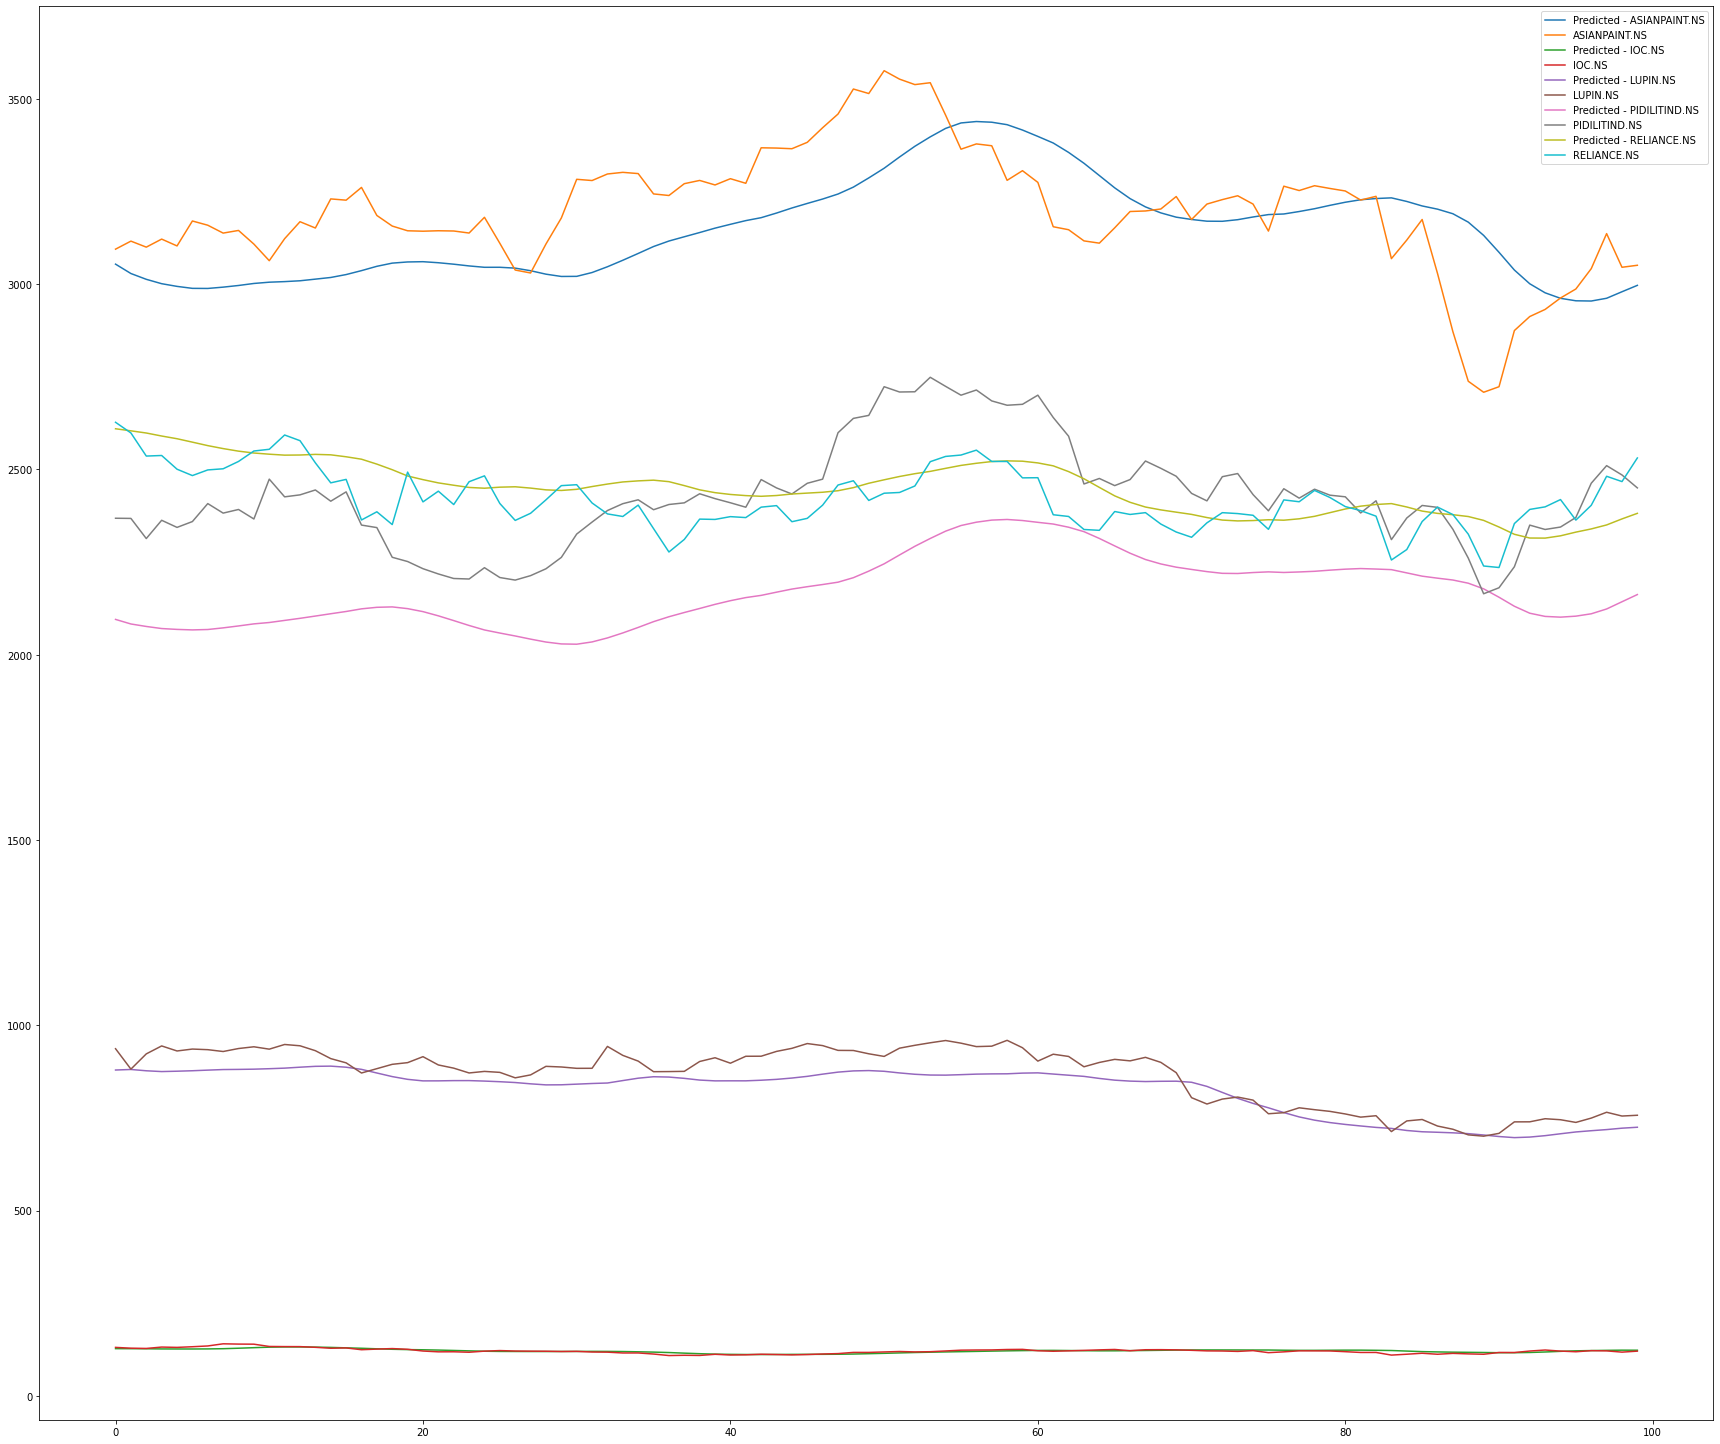

In [ ]:
score = model.evaluate(X_test_new, y_test_new)

print('Score: {}'.format(score))

yhat = model.predict(X_test_new)

# inverse transform is used to convert the scaled values back to original values

# predicted output
yhat = y_scale.inverse_transform(yhat)

# original output
y_test = y_scale.inverse_transform(y_test_new)

# Prediction plot
plt.figure(figsize = (30,26))

for i in range(len(tickers)):
  plt.plot(yhat[-100:, i], label = f'Predicted - {tickers[i]}')
  plt.plot(y_test[-100:, i], label = tickers[i])

plt.legend()
# plt.legend(handles = [pred, orig], labels = [[f'Predicted - {x}' for x in tickers], tickers])
plt.show()

## Next day stock price prediction (Portfolio)

In [ ]:
load_model = load_model("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print("Model loaded!")

Model loaded!


In [ ]:
df_pred = get_data(tickers, False)

[*********************100%***********************]  5 of 5 completed


In [ ]:
df_pred = df_pred["Close"]

In [ ]:
df_pred

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-21,3045.750000,118.000000,755.150024,2485.250000,2467.399902


In [ ]:
df_pred = df_pred.iloc[len(df_pred) - time_steps:len(df_pred), :]
df_pred = df_pred.values
df_pred

array([[3116.30004883,  128.6499939 ,  881.75      , 2368.        ,
        2598.60009766],
       [3100.10009766,  127.94999695,  922.90002441, 2313.64990234,
        2536.25      ],
       [3121.80004883,  131.6499939 ,  944.34997559, 2362.94995117,
        2537.80004883],
       [3103.35009766,  130.80000305,  930.75      , 2343.75      ,
        2500.80004883],
       [3170.64990234,  132.55000305,  935.90002441, 2359.5       ,
        2483.60009766],
       [3159.25      ,  134.6499939 ,  934.25      , 2408.        ,
        2498.85009766],
       [3138.        ,  140.44999695,  929.29998779, 2382.30004883,
        2501.94995117],
       [3145.14990234,  139.69999695,  937.34997559, 2392.10009766,
        2521.69995117],
       [3108.30004883,  139.44999695,  942.04998779, 2366.44995117,
        2549.89990234],
       [3063.5       ,  133.30000305,  935.65002441, 2474.        ,
        2554.55004883],
       [3122.89990234,  132.94999695,  948.25      , 2426.19995117,
        2593

In [ ]:
x_pred = x_scale.transform(df_pred)

print(x_pred.shape)

(100, 5)


In [ ]:
next_day_price = load_model.predict(x_pred.reshape(-1, x_pred.shape[0], x_pred.shape[1]))

In [ ]:
print(y_scale.inverse_transform(next_day_price))

[[3033.3398    116.084206  749.45996  2386.426    2505.0662  ]]


# Helper functions

## Calculate expected returns, annual volatility and Sharpe ratio of optimized portfolio

In [ ]:
def get_port_stats(returns, weights, cov_matrix):
  # EXPECTED ANNUAL RETURN (252 is the approx number of trading days in a year)
  annual_returns = returns.mean() * 252
  # find expected portfolio returns
  expected_return = np.sum(weights.T.values * annual_returns.values)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix * 252,weights)))

  # SHARPE RATIO (Assuming 0 risk free return. Alternative is to use a value of 0.02)
  sharpe_ratio = expected_return / volatility

  print(f"Expected Returns: {(expected_return * 100).round(decimals = 2)}%")
  print(f"Annual Volatility: {(volatility * 100).round(decimals = 2)[0][0]}%")
  print(f"Sharpe Ratio: {sharpe_ratio.round(decimals = 2)[0][0]}")

  return (expected_return * 100).round(decimals = 2), (volatility * 100).round(decimals = 2)[0][0], sharpe_ratio.round(decimals = 2)[0][0]

## Calculate CVaR of each asset

In [22]:
def get_CVaR(pct_change):

  cvar_list = []

  for i in range(port_len):
    print(f'The worst case loss for {tickers[i]} is {round(rp.RiskFunctions.CVaR_Hist(pct_change.iloc[:, i]) * 100, 2)}% and we can conclude this with a confidence of 95%.')
    cvar_list.append(rp.RiskFunctions.CVaR_Hist(pct_change.iloc[:, i]))

  cvar_df = pd.DataFrame(cvar_list, index = tickers);

  return cvar_df

## Calculating reduction factor

In [23]:
def get_reduction_factor(cvar_list, max_range = 0.25):

  scaler = MinMaxScaler(feature_range=(0, max_range))

  scaled_data = scaler.fit_transform(np.array(cvar_list).reshape(-1,1))

  f = lambda x: 1 - x

  return f(scaled_data)

## Softmax function

In [81]:
def softmax(x):
  """Compute softmax values for each sets of scores in x."""
  return np.exp(x) / np.sum(np.exp(x), axis=0)

## Calculating Piotroski F-Score

The Piotroski Score is calculated based on nine criteria that can be grouped into three different categories:
1. **Category 1: Profitability**
> - Net Income > 0 (Score +1)
> - Return on Asset (ROA) > 0 (Score +1)
> - Cash flow from operating activities (CFO) > 0 (Score +1)
> - CFO > Net Income (Score +1)
1. **Category 2: Leverage, Liquidity, and Source of Funds**
> - Long Term Debt [Current Year] < Long Term Debt [Previous Year] (Score +1)
> - Current Ratio [Current Year] > Current Ratio [Previous Year] (Score +1)
> - No new shares issued in the last year (Score +1)
1. **Category 3: Operating Efficiency**
> - Gross Margin [Current Year] > Gross Margin [Previous Year] (Score +1)
> - Asset Turnover Ratio [Current Year] > Asset Turnover Ratio [Previous Year] (Score +1)
---
With each criterion met, a score of 1 will be merited. 

```
Good or high score = 7, 8, 9
Bad or low score = 0, 1, 2, 3
```

Reference - https://www.investopedia.com/terms/p/piotroski-score.asp



### Helper functions for calculating Piotroski Score

In [67]:
# Getting the net income of an asset
def get_net_income(income_df):
  return float(income_df.loc['Net Income'][0])

# Get return on asset
def get_roa(balance_df, income_df):
  current = float(balance_df.loc['Total Assets'][0])
  previous = float(balance_df.loc['Total Assets'][1])

  av_assets=(current+previous)/2

  return get_net_income(income_df)/av_assets

# Get operating cash flow
def get_ocf(cash_df):
  return float(cash_df.loc['Total Cash From Operating Activities'][0])

# Get long term debt
def get_ltdebt(balance_df):
  if 'Long Term Debt' in balance_df.index:
    current = float(balance_df.loc['Long Term Debt'][0])
    previous = float(balance_df.loc['Long Term Debt'][1])

    return previous-current

  return 0

# Get current ratio
def get_current_ratio(balance_df):
  current_TCA = float(balance_df.loc['Total Current Assets'][0])
  previous_TCA = float(balance_df.loc['Total Current Assets'][1])
  current_TCL = float(balance_df.loc['Total Current Liabilities'][0])
  previous_TCL = float(balance_df.loc['Total Current Liabilities'][1])
  
  ratio1 = current_TCA/current_TCL
  ratio2 = previous_TCA/previous_TCL
  
  return ratio1-ratio2

# Get count of new shares if issued
def get_new_shares(balance_df):
  current = float(balance_df.loc['Common Stock'][0])
  previous = float(balance_df.loc['Common Stock'][1])
  
  return current-previous

# Get gross margin
def get_gross_margin(income_df):
  current = float(income_df.loc['Gross Profit'][0])/float(income_df.loc['Total Revenue'][0])
  previous =  float(income_df.loc['Gross Profit'][1])/float(income_df.loc['Total Revenue'][1])

  return current-previous


# Get asset turnover ratio
def get_asset_turnover_ratio(income_df, balance_df):
  current = float(balance_df.loc['Total Assets'][0])
  prev_1 = float(balance_df.loc['Total Assets'][1])
  prev_2 = float(balance_df.loc['Total Assets'][2])
  
  av_assets1 = (current+prev_1)/2
  av_assets2 = (prev_1+prev_2)/2
  
  atr1 = float(income_df.loc['Total Revenue'][0])/av_assets1
  atr2 = float(income_df.loc['Total Revenue'][1])/av_assets2

  return atr1-atr2

In [70]:
def get_piotroski_score(income_df, balance_df, cash_df):
  score=0
  passed = []

  print(f"Net income - {get_net_income(income_df)}")
  
  if get_net_income(income_df)>0:
    passed.append("Net income")
    score+=1

  print(f'ROA - {get_roa(balance_df, income_df)}')
  
  if get_roa(balance_df, income_df)>0:
    passed.append("ROA")
    score+=1

  print(f"Operating Cash flow - {get_ocf(cash_df)}")
     
  if get_ocf(cash_df)>0:
    passed.append("CFO")
    score+=1

  print(f"Operating Cash flow > Net Income - {get_ocf(cash_df)>get_net_income(income_df)}")
      
  if get_ocf(cash_df)>get_net_income(income_df):
    passed.append("CFO > NI")
    score+=1

  print(f"Long term debt - {get_ltdebt(balance_df)}")
      
  if get_ltdebt(balance_df)>0:
    passed.append("LTD")
    score+=1

  print(f"Current ratio - {get_current_ratio(balance_df)}")
      
  if get_current_ratio(balance_df)>0:
    passed.append("CR")
    score+=1

  print(f"New shares count - {get_new_shares(balance_df)}")
      
  if get_new_shares(balance_df)>0:
    passed.append("New shares")
    score+=1

  print(f"New shares count - {get_gross_margin(income_df)}")
      
  if get_gross_margin(income_df)>0:
    passed.append("GM")
    score+=1

  print((f"Asset turnover ratio - {get_asset_turnover_ratio(income_df, balance_df)}"))
      
  if get_asset_turnover_ratio(income_df, balance_df)>0:
    passed.append("ATR")
    score+=1

  print(f'Passed metrics - {passed}')
      
  return score

# Calculating RoE (Return on Equity)

Negative RoE -  When a company incurs a loss, hence no net income, return on equity is negative. 

Reference - https://towardsdatascience.com/calculating-return-on-equity-with-python-1ea583cd53bd

In [83]:
def get_roe(income_df, balance_df):
  ni = float(income_df.loc['Net Income'][0])

  eq1 = balance_df.loc["Total Stockholder Equity"][0]
  eq2 = balance_df.loc["Total Stockholder Equity"][1]

  avg_eq = (eq1+eq2)/2
  roe = ni/avg_eq

  return roe

# Fundamentals analyser

## Calculating Piotroski score for all assets

In [93]:
def calc_piotroski_score(ticker, income_df, balance_df, cash_df):

  ps = get_piotroski_score(income_df, balance_df, cash_df)
  print(f'Piotroski score for {ticker} is {ps}')

  return ps

In [101]:
def calc_roe(ticker, income_df, balance_df):
  roe = get_roe(income_df, balance_df)
  print(f'RoE for {ticker} is {round(roe * 100, 2)}%')

  return roe

In [102]:
def fundamentals_analyser(tickers):
  # Calculating Piotroski score, RoE for all assets in portfolio
  for t in tickers:
    # Getting balance sheet, income statement and financials of the asset
    income_df = extra_info_tickers.tickers[t].financials.dropna()
    balance_df = extra_info_tickers.tickers[t].balance_sheet.dropna()
    cash_df = extra_info_tickers.tickers[t].cashflow.dropna()

    print("PIOTROSKI SCORE")
    calc_piotroski_score(t, income_df, balance_df, cash_df)
    print("--------------------------")
    print("RoE")
    calc_roe(t, income_df, balance_df)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")

In [103]:
fundamentals_analyser(tickers)

PIOTROSKI SCORE
Net income - 3601600000.0
ROA - 0.10807534306179463
Operating Cash flow - 9771100000.0
Operating Cash flow > Net Income - True
Long term debt - 2208500000.0
Current ratio - 0.00337540397191316
New shares count - 1100000.0
New shares count - 0.008383182026031777
Asset turnover ratio - -0.006828739807113404
Passed metrics - ['Net income', 'ROA', 'CFO', 'CFO > NI', 'LTD', 'CR', 'New shares', 'GM']
Piotroski score for APLAPOLLO.NS is 8
--------------------------
RoE
RoE for APLAPOLLO.NS is 23.61%
~~~~~~~~~~~~~~~~~~~~~~~~~~
PIOTROSKI SCORE
Net income - 1003500000.0
ROA - 0.02871774619350352
Operating Cash flow - 3498100000.0
Operating Cash flow > Net Income - True
Long term debt - -3015500000.0
Current ratio - 0.22302588000966916
New shares count - 0.0
New shares count - -0.017902186231301492
Asset turnover ratio - -0.3586606751138508
Passed metrics - ['Net income', 'ROA', 'CFO', 'CFO > NI', 'CR']
Piotroski score for BLUESTARCO.NS is 5
--------------------------
RoE
RoE for 

# Calculating percentage change and covariance matrix

In [19]:
pct_change = df.pct_change().dropna()
cov = np.cov(pct_change.T)

In [20]:
# Covariance matrix representation

col_index = dict()

for i in range(port_len):
  col_index[i] = tickers[i]

pd_cov = pd.DataFrame(cov, index = [tickers])
pd_cov = pd_cov.rename(col_index, axis=1)
pd_cov

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.000671,0.000138,0.000196,0.000171,0.000130,0.000184,0.000154,0.000180,0.000179,0.000111,0.000219
BLUESTARCO.NS,0.000138,0.000419,0.000139,0.000121,0.000086,0.000131,0.000119,0.000134,0.000110,0.000071,0.000129
BSOFT.NS,0.000196,0.000139,0.000892,0.000336,0.000165,0.000226,0.000207,0.000213,0.000161,0.000092,0.000266
COFORGE.NS,0.000171,0.000121,0.000336,0.000808,0.000098,0.000168,0.000146,0.000161,0.000164,0.000060,0.000183
CUMMINSIND.NS,0.000130,0.000086,0.000165,0.000098,0.000441,0.000145,0.000147,0.000154,0.000097,0.000054,0.000157
DHAMPURSUG.NS,0.000184,0.000131,0.000226,0.000168,0.000145,0.001319,0.000242,0.000246,0.000140,0.000141,0.000250
SBIN.NS,0.000154,0.000119,0.000207,0.000146,0.000147,0.000242,0.000569,0.000254,0.000165,0.000101,0.000191
TATAPOWER.NS,0.000180,0.000134,0.000213,0.000161,0.000154,0.000246,0.000254,0.000633,0.000165,0.000117,0.000232
TRENT.NS,0.000179,0.000110,0.000161,0.000164,0.000097,0.000140,0.000165,0.000165,0.000549,0.000081,0.000156
VTL.NS,0.000111,0.000071,0.000092,0.000060,0.000054,0.000141,0.000101,0.000117,0.000081,0.000417,0.000134


# Deep Learning Model for Portfolio Optimization [Method 1]

## Custom loss function with reduction factor (based on CVaR risk measure)

In [17]:
def calc_reduction_factor(pct_change):
  # getting CVaR for each asset in the portfolio
  cvar_df = get_CVaR(pct_change)

  rf = get_reduction_factor(cvar_df[0])

  return rf

In [24]:
tf_port_data = tf.cast(tf.constant(df.iloc[1:]), float)
reduction_factor = calc_reduction_factor(pct_change)
tf_reduction_factor = tf.cast(tf.constant(reduction_factor), float)
tf_reduction_factor

The worst case loss for APLAPOLLO.NS is 5.31% and we can conclude this with a confidence of 95%.
The worst case loss for BLUESTARCO.NS is 4.32% and we can conclude this with a confidence of 95%.
The worst case loss for BSOFT.NS is 6.45% and we can conclude this with a confidence of 95%.
The worst case loss for COFORGE.NS is 6.07% and we can conclude this with a confidence of 95%.
The worst case loss for CUMMINSIND.NS is 4.47% and we can conclude this with a confidence of 95%.
The worst case loss for DHAMPURSUG.NS is 7.55% and we can conclude this with a confidence of 95%.
The worst case loss for SBIN.NS is 5.1% and we can conclude this with a confidence of 95%.
The worst case loss for TATAPOWER.NS is 5.35% and we can conclude this with a confidence of 95%.
The worst case loss for TRENT.NS is 4.55% and we can conclude this with a confidence of 95%.
The worst case loss for VTL.NS is 4.47% and we can conclude this with a confidence of 95%.
The worst case loss for ZENTEC.NS is 6.45% and we

<tf.Tensor: shape=(11, 1), dtype=float32, numpy=
array([[0.92347467],
       [1.        ],
       [0.83512825],
       [0.864809  ],
       [0.98854554],
       [0.75      ],
       [0.9401553 ],
       [0.9208527 ],
       [0.9822356 ],
       [0.98882216],
       [0.83508486]], dtype=float32)>

In [ ]:
def sharpe_loss(_, y_pred):
  '''
  data.shape -> (lookback_period, port_len)
  y_pred.shape -> (None, port_len)
  '''
  new_weights = tf.multiply(tf_reduction_factor, tf.transpose(y_pred))

  # using softmax function formula
  new_y_pred = (tf.math.exp(new_weights) / tf.reduce_sum(tf.math.exp(new_weights), axis=0))

  # make all time-series start at 1 (Scaling down prices for fast multiplication)
  data = tf.divide(tf_port_data, tf_port_data[0])  
            
  # value of the portfolio after allocations applied
  portfolio_values = tf.reduce_sum(tf.multiply(data, tf.transpose(new_y_pred)), axis=1) 
  
  portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

  sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

  # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
  # we can negate Sharpe (the min of a negated function is its max)
  return -sharpe

In [ ]:
# Historical data with returns
df_w_ret = np.concatenate([df.values[1:], df.pct_change().dropna().values[0:]], axis=1)

df_w_ret.shape

(1236, 22)

In [ ]:
del opt_model

In [ ]:
opt_model = Sequential([
            LSTM(64, input_shape=df_w_ret.shape),
            Flatten(),
            Dense(port_len, activation='softmax') 
        ])

In [ ]:
# FOR TESTING:
# opt_model.compile(loss=sharpe_loss, optimizer='adam', run_eagerly=True)
  
# FOR PRODUCTION:
opt_model.compile(loss=sharpe_loss, optimizer='adam')

In [ ]:
opt_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                22272     
                                                                 
 flatten_27 (Flatten)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 11)                715       
                                                                 
Total params: 22,987
Trainable params: 22,987
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_predict_data = df_w_ret[np.newaxis,:]
fit_predict_data.shape

(1, 1236, 22)

In [ ]:
with tf.device('/device:GPU:0'):
  opt_model.fit(fit_predict_data, np.zeros((1, port_len)), epochs=50, shuffle=False)

In [ ]:
pred_weights_1 = opt_model.predict(fit_predict_data).T
pred_weights_1 = pd.DataFrame(pred_weights_1)
pred_weights_1

In [ ]:
erDLm1, cvDLm1, srDLm1 = get_port_stats(pct_change, pred_weights_1, cov)

## Replication of custom sharpe loss function

In [ ]:
df.iloc[1:]

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-29,117.190002,651.099976,81.340538,425.549988,932.950012,214.399994,288.450012,90.000000,249.000000,258.630005,69.050003
2017-03-30,118.489998,668.299988,81.216209,420.049988,940.400024,219.949997,291.049988,89.900002,256.149994,262.320007,68.300003
2017-03-31,117.445000,692.400024,80.625664,435.600006,949.450012,216.850006,293.399994,90.349998,266.700012,262.529999,66.550003
2017-04-03,120.254997,716.000000,80.812149,434.950012,961.549988,224.149994,293.149994,89.199997,271.899994,271.769989,67.150002
2017-04-05,120.724998,694.200012,80.936478,433.149994,968.750000,219.899994,297.350006,88.199997,271.700012,270.950012,71.099998
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,963.849976,978.750000,443.750000,4433.899902,1054.000000,532.799988,490.600006,227.949997,1279.599976,520.869995,197.100006
2022-03-22,938.049988,984.750000,465.899994,4457.700195,1051.849976,533.799988,493.700012,231.399994,1286.349976,513.090027,195.750000
2022-03-23,908.700012,995.049988,467.549988,4435.450195,1087.050049,533.599976,490.649994,234.300003,1300.250000,527.789978,195.750000


In [ ]:
df.iloc[1:] / df.iloc[1]

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-03-30,1.011093,1.026417,0.998472,0.987076,1.007985,1.025886,1.009014,0.998889,1.028715,1.014267,0.989138
2017-03-31,1.002176,1.063431,0.991211,1.023617,1.017686,1.011427,1.017161,1.003889,1.071084,1.015079,0.963794
2017-04-03,1.026154,1.099678,0.993504,1.022089,1.030655,1.045476,1.016294,0.991111,1.091968,1.050806,0.972484
2017-04-05,1.030165,1.066196,0.995032,1.017859,1.038373,1.025653,1.030855,0.980000,1.091165,1.047636,1.029689
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,8.224677,1.503225,5.455459,10.419222,1.129750,2.485075,1.700815,2.532778,5.138956,2.013958,2.854453
2022-03-22,8.004522,1.512441,5.727771,10.475151,1.127445,2.489739,1.711562,2.571111,5.166064,1.983877,2.834902
2022-03-23,7.754075,1.528260,5.748056,10.422865,1.165175,2.488806,1.700988,2.603333,5.221888,2.040714,2.834902


In [ ]:
# using a sample set of equal weights for all assets in portfolio and replicating the custom loss function
# calculations
pd.DataFrame(np.multiply((df.iloc[1:] / df.iloc[1]).values, np.array([1 / port_len for x in range(port_len)])))

,0,1,2,3,4,5,6,7,8,9,10
0,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
1,0.091918,0.093311,0.090770,0.089734,0.091635,0.093262,0.091729,0.090808,0.093520,0.092206,0.089922
2,0.091107,0.096676,0.090110,0.093056,0.092517,0.091948,0.092469,0.091263,0.097371,0.092280,0.087618
3,0.093287,0.099971,0.090319,0.092917,0.093696,0.095043,0.092390,0.090101,0.099270,0.095528,0.088408
4,0.093651,0.096927,0.090457,0.092533,0.094398,0.093241,0.093714,0.089091,0.099197,0.095240,0.093608
...,...,...,...,...,...,...,...,...,...,...,...
1229,0.747698,0.136657,0.495951,0.947202,0.102705,0.225916,0.154620,0.230253,0.467178,0.183087,0.259496
1230,0.727684,0.137495,0.520706,0.952286,0.102495,0.226340,0.155597,0.233737,0.469642,0.180352,0.257718
1231,0.704916,0.138933,0.522551,0.947533,0.105925,0.226255,0.154635,0.236667,0.474717,0.185519,0.257718
1232,0.699524,0.139638,0.536577,0.956826,0.106602,0.231322,0.153516,0.241919,0.466174,0.189794,0.257587


In [ ]:
data = tf.divide(tf_port_data, tf_port_data[0])  
data.shape

TensorShape([1234, 11])

# Deep learning Model for Portfolio Optimization [Method 2] (Not important)

In [ ]:
def sharpe_loss_2(_, y_pred):

  y_pred = tf.cast(y_pred, dtype = tf.float64)
  cov_tensor = tf.convert_to_tensor(cov, dtype=tf.float64)
  pct_change_tensor = tf.convert_to_tensor(pct_change, dtype=tf.float64)

  # EXPECTED ANNUAL RETURN
  annual_returns = K.mean(pct_change_tensor) * 252
  # find expected portfolio returns
  expected_return = tf.reduce_sum(tf.transpose(y_pred) * annual_returns)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = tf.sqrt(tf.matmul(y_pred,tf.matmul(cov_tensor*252,tf.transpose(y_pred))))

  # SHARPE RATIO (Assuming 0 risk free return)
  sharpe_ratio = expected_return / volatility

  if sharpe_ratio > 0:
    return -sharpe_ratio
  else:
    return sharpe_ratio

In [ ]:
def gen_model(input_shape, outputs):
  model = Sequential([
              GRU(128, input_shape=input_shape, return_sequences = True),
              GRU(64),
              Flatten(),
              Dense(outputs, activation='softmax')
          ])

  # FOR TESTING:
  # model.compile(loss=sharpe_loss_2, optimizer='adam', run_eagerly=True)
  
  # FOR PRODUCTION:
  model.compile(loss=sharpe_loss_2, optimizer='adam')

  return model

In [ ]:
# Historical data concatenated with returns (for momentum purpose as explained in the paper "Deep
# learning for portfolio optimization")
df_w_ret = np.concatenate([ df.values[1:], df.pct_change().values[1:] ], axis=1)

In [ ]:
df_w_ret[0]

array([ 1.18330002e+02,  6.15900024e+02,  8.13716202e+01,  4.25000000e+02,
        9.37150024e+02,  2.24050003e+02,  2.82100006e+02,  8.88000031e+01,
        2.46300003e+02,  2.59989990e+02,  6.65000000e+01,  1.56209738e-02,
       -7.49329380e-03,  7.31054078e-03, -2.35253122e-04,  1.07312468e-02,
       -1.27781182e-02,  9.48289061e-03,  1.71821300e-02,  2.51821147e-02,
       -4.82300389e-03, -5.23557939e-03])

In [ ]:
opt_model_x = df_w_ret[np.newaxis, :]

opt_model_x.shape

(1, 1235, 22)

In [ ]:
opt_model_2 = gen_model(np.array([opt_model_x.shape[1], opt_model_x.shape[2]]), port_len)

In [ ]:
with tf.device('/device:GPU:0'):
  # Here Y [np.zeros((1, port_len))] does not matter because we don't use y_true in 
  # the custom loss function
  opt_model_2.fit(opt_model_x, np.zeros((1, port_len)), epochs=50, shuffle=False)

Epoch 1/50
1/1 [==============================] - 17s 17s/step - loss: -1.4235
Epoch 2/50
1/1 [==============================] - 12s 12s/step - loss: -1.5180
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: -1.5441
Epoch 4/50
1/1 [==============================] - 11s 11s/step - loss: -1.5496
Epoch 5/50
1/1 [==============================] - 12s 12s/step - loss: -1.5603
Epoch 6/50
1/1 [==============================] - 11s 11s/step - loss: -1.5730
Epoch 7/50
1/1 [==============================] - 12s 12s/step - loss: -1.5835
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: -1.5958
Epoch 9/50
1/1 [==============================] - 11s 11s/step - loss: -1.6060
Epoch 10/50
1/1 [==============================] - 11s 11s/step - loss: -1.6110
Epoch 11/50
1/1 [==============================] - 11s 11s/step - loss: -1.6077
Epoch 12/50
1/1 [==============================] - 11s 11s/step - loss: -1.6036
Epoch 13/50
1/1 [==============================] 

In [ ]:
pred_weights_2 = opt_model_2.predict(opt_model_x).T
pred_weights_2 = pd.DataFrame(pred_weights_2)
pred_weights_2

,0
0,0.044639
1,0.196646
2,0.005666
3,0.076830
4,0.206292
5,0.006700
6,0.061958
7,0.029194
8,0.118983
9,0.248855


In [ ]:
erDL, cvDL, srDL = get_port_stats(pct_change, pred_weights_2, cov)

Expected Returns: 23.9%
Annual Volatility: 20.22%
Sharpe Ratio: 1.18


# Statistical models (PyPortfolioOpt)

In [ ]:
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns

<AxesSubplot:xlabel='Date'>

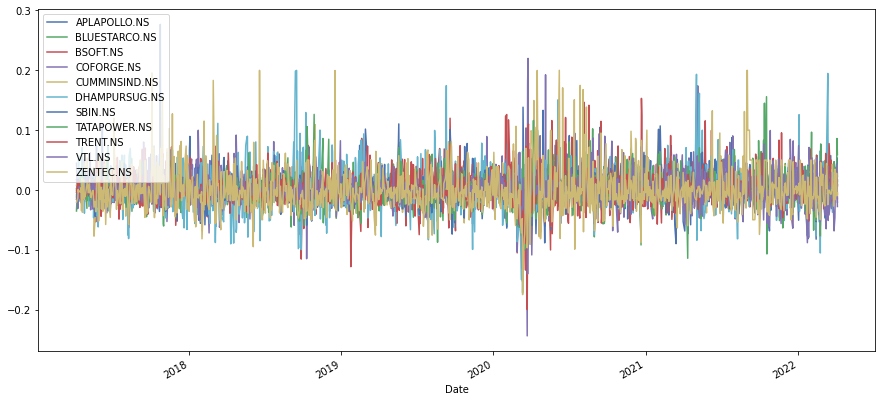

In [ ]:
pct_change.plot(label = tickers, figsize = (15,7))

## HRP (Hierarchical Risk Parity)

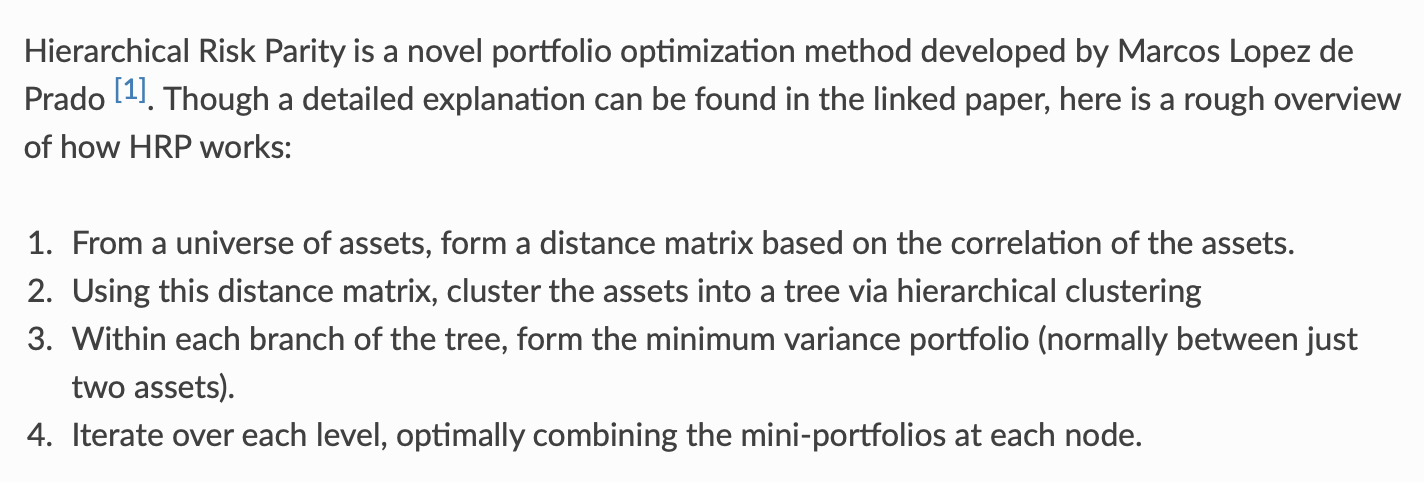

Here since Minimum variance portfolio is formed, the returns will obviously be low.

In [ ]:
# Using Hierarchical Risk Parity method to compute optimized portfolio weights
hrp = HRPOpt(pct_change)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('APLAPOLLO.NS', 0.07555),
             ('BLUESTARCO.NS', 0.16058),
             ('BSOFT.NS', 0.06281),
             ('COFORGE.NS', 0.0772),
             ('CUMMINSIND.NS', 0.11475),
             ('DHAMPURSUG.NS', 0.04249),
             ('SBIN.NS', 0.06951),
             ('TATAPOWER.NS', 0.06272),
             ('TRENT.NS', 0.10267),
             ('VTL.NS', 0.17944),
             ('ZENTEC.NS', 0.05229)])

In [ ]:
risk_models.sample_cov(df) # covariance matrix

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.168916,0.034822,0.049316,0.042962,0.032724,0.046278,0.038809,0.044963,0.044841,0.027901,0.055513
BLUESTARCO.NS,0.034822,0.105891,0.034940,0.030138,0.021569,0.033196,0.030066,0.033819,0.027830,0.018104,0.032570
BSOFT.NS,0.049316,0.034940,0.224762,0.084754,0.041685,0.056976,0.052254,0.053737,0.040679,0.023194,0.067100
COFORGE.NS,0.042962,0.030138,0.084754,0.203918,0.024653,0.042226,0.036698,0.040421,0.041323,0.015002,0.046052
CUMMINSIND.NS,0.032724,0.021569,0.041685,0.024653,0.111212,0.036418,0.037039,0.038856,0.024496,0.013455,0.039587
DHAMPURSUG.NS,0.046278,0.033196,0.056976,0.042226,0.036418,0.332264,0.060985,0.061811,0.035328,0.035455,0.063316
SBIN.NS,0.038809,0.030066,0.052254,0.036698,0.037039,0.060985,0.143525,0.063949,0.041613,0.025455,0.048146
TATAPOWER.NS,0.044963,0.033819,0.053737,0.040421,0.038856,0.061811,0.063949,0.159067,0.041366,0.029384,0.058985
TRENT.NS,0.044841,0.027830,0.040679,0.041323,0.024496,0.035328,0.041613,0.041366,0.138244,0.020466,0.039473
VTL.NS,0.027901,0.018104,0.023194,0.015002,0.013455,0.035455,0.025455,0.029384,0.020466,0.105252,0.033973


In [ ]:
weightsdf1 = pd.DataFrame.from_dict(weights, orient="index")
weightsdf1 = weightsdf1.rename({0: 'weights'}, axis=1)
weightsdf1

,weights
APLAPOLLO.NS,0.07555
BLUESTARCO.NS,0.16058
BSOFT.NS,0.06281
COFORGE.NS,0.07720
CUMMINSIND.NS,0.11475
DHAMPURSUG.NS,0.04249
SBIN.NS,0.06951
TATAPOWER.NS,0.06272
TRENT.NS,0.10267
VTL.NS,0.17944


<AxesSubplot:xlabel='Weight'>

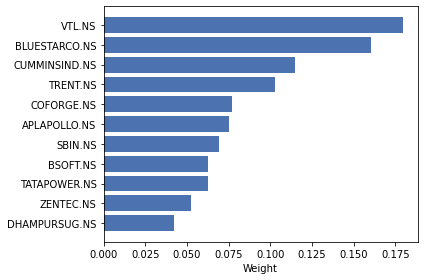

In [ ]:
plotting.plot_weights(weights)

In [ ]:
weightsdf1.iloc[:, 0].sum()

1.00001

In [ ]:
hrp.portfolio_performance(risk_free_rate=0, verbose=True)

Expected annual return: 28.7%
Annual volatility: 21.1%
Sharpe Ratio: 1.36


(0.2869746544621335, 0.21089594422446492, 1.360740508867705)

In [ ]:
erW1Plib, cvW1Plib, srW1Plib = get_port_stats(pct_change, weightsdf1, cov)

Expected Returns: 28.7%
Annual Volatility: 21.09%
Sharpe Ratio: 1.36


<AxesSubplot:>

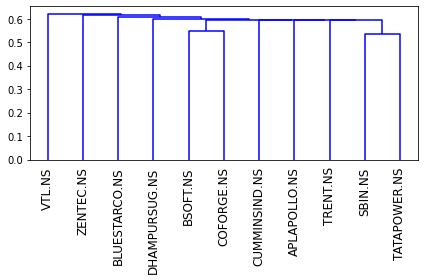

In [ ]:
plotting.plot_dendrogram(hrp) 

## CLA (Critical Line Algorithm)

In [ ]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df) # covariance matrix

In [ ]:
mu

APLAPOLLO.NS     0.551159
BLUESTARCO.NS    0.111137
BSOFT.NS         0.439039
COFORGE.NS       0.616060
CUMMINSIND.NS    0.031962
DHAMPURSUG.NS    0.214024
SBIN.NS          0.121512
TATAPOWER.NS     0.277146
TRENT.NS         0.384953
VTL.NS           0.107057
ZENTEC.NS        0.247710
dtype: float64

In [ ]:
S

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.168916,0.034822,0.049316,0.042962,0.032724,0.046278,0.038809,0.044963,0.044841,0.027901,0.055513
BLUESTARCO.NS,0.034822,0.105891,0.034940,0.030138,0.021569,0.033196,0.030066,0.033819,0.027830,0.018104,0.032570
BSOFT.NS,0.049316,0.034940,0.224762,0.084754,0.041685,0.056976,0.052254,0.053737,0.040679,0.023194,0.067100
COFORGE.NS,0.042962,0.030138,0.084754,0.203918,0.024653,0.042226,0.036698,0.040421,0.041323,0.015002,0.046052
CUMMINSIND.NS,0.032724,0.021569,0.041685,0.024653,0.111212,0.036418,0.037039,0.038856,0.024496,0.013455,0.039587
DHAMPURSUG.NS,0.046278,0.033196,0.056976,0.042226,0.036418,0.332264,0.060985,0.061811,0.035328,0.035455,0.063316
SBIN.NS,0.038809,0.030066,0.052254,0.036698,0.037039,0.060985,0.143525,0.063949,0.041613,0.025455,0.048146
TATAPOWER.NS,0.044963,0.033819,0.053737,0.040421,0.038856,0.061811,0.063949,0.159067,0.041366,0.029384,0.058985
TRENT.NS,0.044841,0.027830,0.040679,0.041323,0.024496,0.035328,0.041613,0.041366,0.138244,0.020466,0.039473
VTL.NS,0.027901,0.018104,0.023194,0.015002,0.013455,0.035455,0.025455,0.029384,0.020466,0.105252,0.033973


In [ ]:
cla = CLA(mu, S)
cla.max_sharpe()
weights2 = cla.clean_weights()
weightsdf2 = pd.DataFrame.from_dict(weights2, orient="index")
weightsdf2 = weightsdf2.rename({0: 'weights'}, axis=1)
weightsdf2

,weights
APLAPOLLO.NS,0.36543
BLUESTARCO.NS,0.00000
BSOFT.NS,0.06761
COFORGE.NS,0.34184
CUMMINSIND.NS,0.00000
DHAMPURSUG.NS,0.00000
SBIN.NS,0.00000
TATAPOWER.NS,0.01686
TRENT.NS,0.20827
VTL.NS,0.00000


<AxesSubplot:xlabel='Weight'>

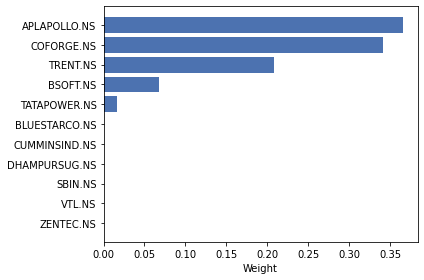

In [ ]:
plotting.plot_weights(weights2)

In [ ]:
erW2Plib, cvW2Plib, srW2Plib = cla.portfolio_performance(risk_free_rate=0, verbose=True)
erW2Plib, cvW2Plib, srW2Plib = (erW2Plib * 100).round(decimals = 2), (cvW2Plib * 100).round(decimals = 2), (srW2Plib).round(decimals = 2)

Expected annual return: 52.7%
Annual volatility: 29.3%
Sharpe Ratio: 1.80


<AxesSubplot:xlabel='Volatility', ylabel='Return'>

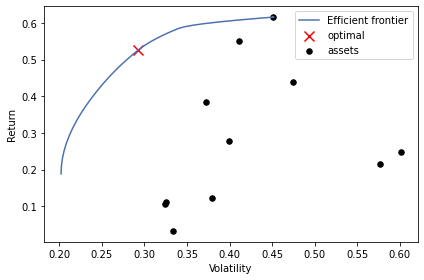

In [ ]:
plotting.plot_efficient_frontier(cla)

# Statistical Models (RiskFolio-Lib) [Best Library]

In [ ]:
# Calculating returns
Y = pct_change
Y

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-04-07,0.017202,-0.035271,-0.000384,0.044463,0.007975,-0.008455,-0.011610,0.002291,-0.004277,-0.015603,-0.020304
2017-04-10,0.003499,0.014155,-0.008452,-0.031278,0.012825,-0.017746,-0.000346,-0.005143,0.012512,-0.002473,-0.014064
2017-04-11,0.009505,0.001642,-0.005037,-0.005828,0.001736,0.003050,0.017798,-0.018380,-0.006455,-0.021224,0.000751
2017-04-12,0.002755,-0.006408,0.020639,0.000352,0.005403,0.057076,-0.014771,0.001170,-0.014851,0.002802,-0.003751
2017-04-13,-0.006069,0.005100,-0.014880,-0.000703,-0.008010,-0.019031,0.004825,-0.009936,0.015451,0.005282,-0.001506
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,-0.014599,0.000380,0.001651,-0.014253,0.012186,0.003849,-0.001517,-0.012619,0.014637,-0.046578,0.034570
2022-04-01,0.029248,0.037736,0.025607,-0.009568,0.013734,0.006733,0.029683,0.028494,-0.005527,0.000344,-0.016341
2022-04-04,0.002072,0.006366,0.011252,0.021915,-0.007434,0.041891,0.008264,0.026482,0.020655,0.044022,0.027771


## Calculating CVaR for each asset of portfolio and reduction factor [Not important]

In [ ]:
# Calculating CVaR for first asset - Using original formula
Y.iloc[:, 0].sort_values(ascending=False).tail(int(.05 * len(Y))).mean()

-0.053307301099272855

In [ ]:
cvar_df = get_CVaR(Y)
cvar_df

The worst case loss for APLAPOLLO.NS is 5.31% and we can conclude this with a confidence of 95%.
The worst case loss for BLUESTARCO.NS is 4.33% and we can conclude this with a confidence of 95%.
The worst case loss for BSOFT.NS is 6.45% and we can conclude this with a confidence of 95%.
The worst case loss for COFORGE.NS is 6.07% and we can conclude this with a confidence of 95%.
The worst case loss for CUMMINSIND.NS is 4.47% and we can conclude this with a confidence of 95%.
The worst case loss for DHAMPURSUG.NS is 7.55% and we can conclude this with a confidence of 95%.
The worst case loss for SBIN.NS is 5.1% and we can conclude this with a confidence of 95%.
The worst case loss for TATAPOWER.NS is 5.34% and we can conclude this with a confidence of 95%.
The worst case loss for TRENT.NS is 4.55% and we can conclude this with a confidence of 95%.
The worst case loss for VTL.NS is 4.47% and we can conclude this with a confidence of 95%.
The worst case loss for ZENTEC.NS is 6.45% and we

,0
APLAPOLLO.NS,0.053064
BLUESTARCO.NS,0.043335
BSOFT.NS,0.064535
COFORGE.NS,0.060699
CUMMINSIND.NS,0.044706
DHAMPURSUG.NS,0.075537
SBIN.NS,0.050960
TATAPOWER.NS,0.053398
TRENT.NS,0.045522
VTL.NS,0.044671


In [ ]:
rf = get_reduction_factor(cvar_df[0])
rf

array([[0.89425559],
       [1.        ],
       [0.76958494],
       [0.81127934],
       [0.9850998 ],
       [0.65      ],
       [0.91712306],
       [0.89062598],
       [0.97623578],
       [0.98548836],
       [0.76952397]])

In [ ]:
rf_mul_weights = np.multiply(rf, np.array([1 / port_len for x in range(port_len)]).T.reshape(-1,1))
rf_mul_weights

array([[0.08129596],
       [0.09090909],
       [0.06996227],
       [0.07375267],
       [0.08955453],
       [0.05909091],
       [0.08337482],
       [0.080966  ],
       [0.08874871],
       [0.08958985],
       [0.06995672]])

In [ ]:
new_weights = softmax(rf_mul_weights)
new_weights

array([[0.09104572],
       [0.09192518],
       [0.09001967],
       [0.09036152],
       [0.09180074],
       [0.08904633],
       [0.09123519],
       [0.09101569],
       [0.0917268 ],
       [0.09180399],
       [0.09001917]])

## HRP (Hierarchical Risk Parity)

Reference - https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [ ]:
model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
rf = 0 # Risk free rate
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
linkage = 'single' # Linkage method used to build clusters
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios
max_k = port_len

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


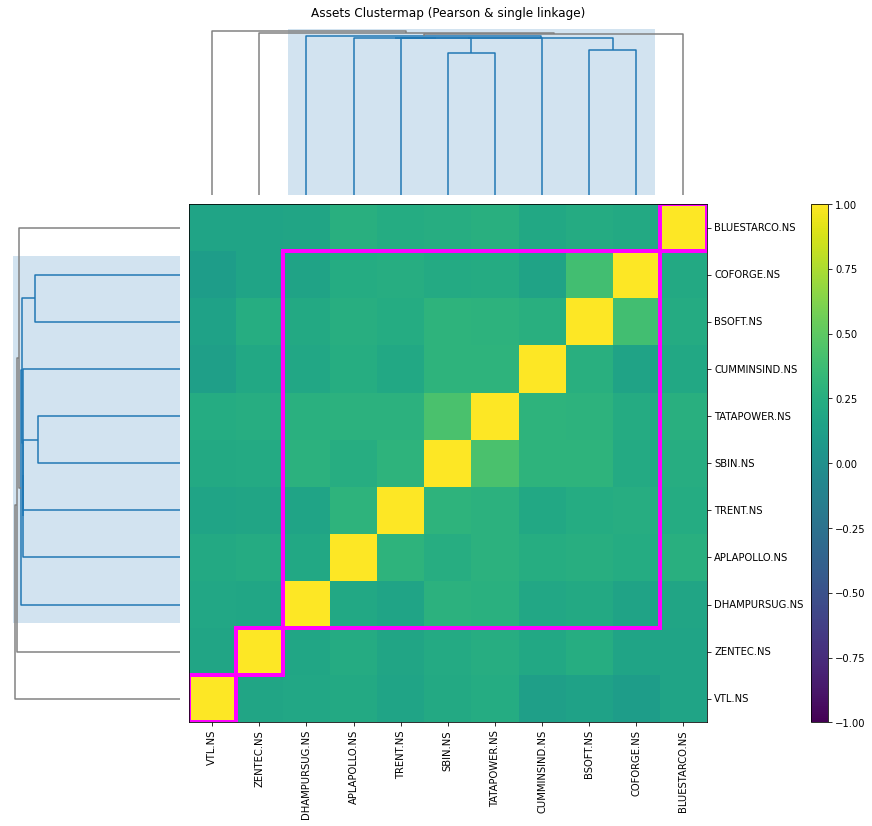

In [ ]:
# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      ax=None)

In [ ]:
# Building the portfolio object
port1 = rp.HCPortfolio(returns=Y)

In [ ]:
# Estimate optimal portfolio:

w1 = port1.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      leaf_order=leaf_order,
                      hist=hist)

display(w1.T)

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
weights,0.071973,0.119905,0.084166,0.178985,0.037029,0.067534,0.109931,0.044009,0.170283,0.068719,0.047465


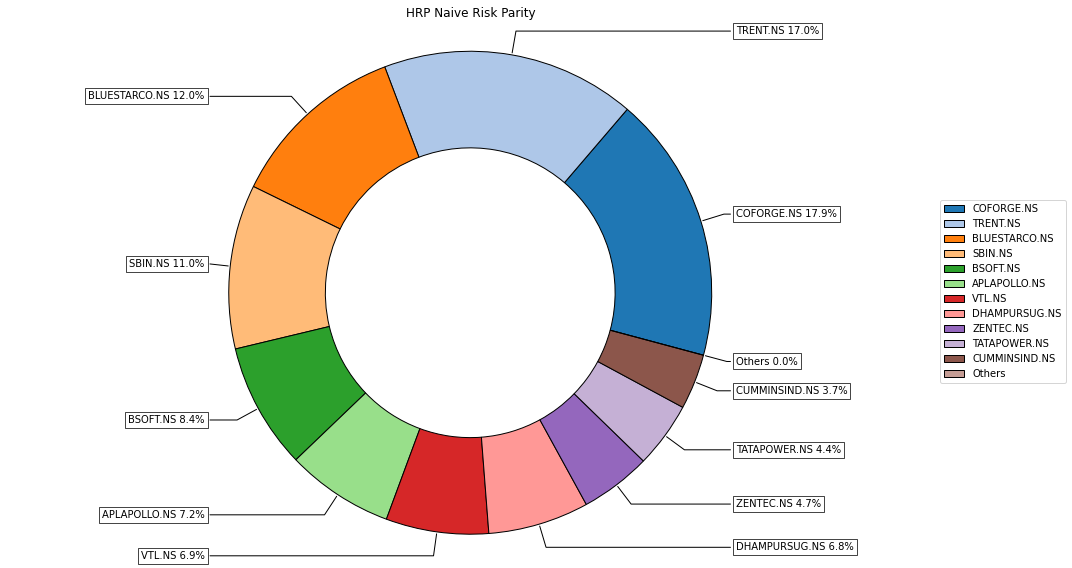

In [ ]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w1,
                 title='HRP Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

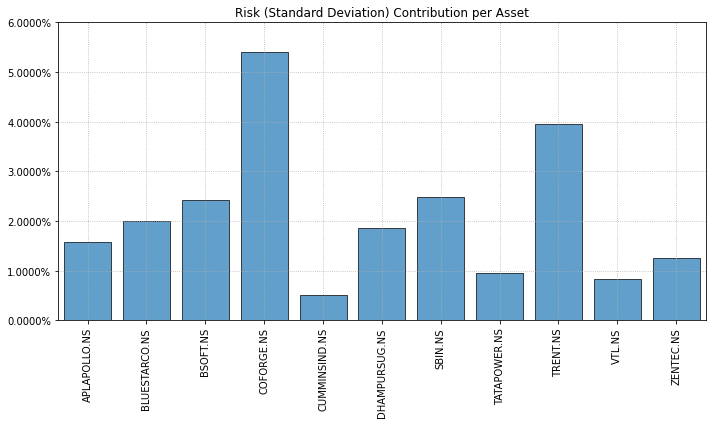

In [ ]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w1,
                 cov=port1.cov, 
                 returns=port1.returns, 
                 ax=None)

In [ ]:
erW1, cvW1, srW1 = get_port_stats(port1.returns, w1, port1.cov)

Expected Returns: 35.94%
Annual Volatility: 23.26%
Sharpe Ratio: 1.55


## HERC (Hierarchical Equal Risk Contribution)

Reference - https://hudsonthames.org/beyond-risk-parity-the-hierarchical-equal-risk-contribution-algorithm/

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [ ]:
model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
linkage = 'complete' # Linkage method used to build clusters
max_k = port_len # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


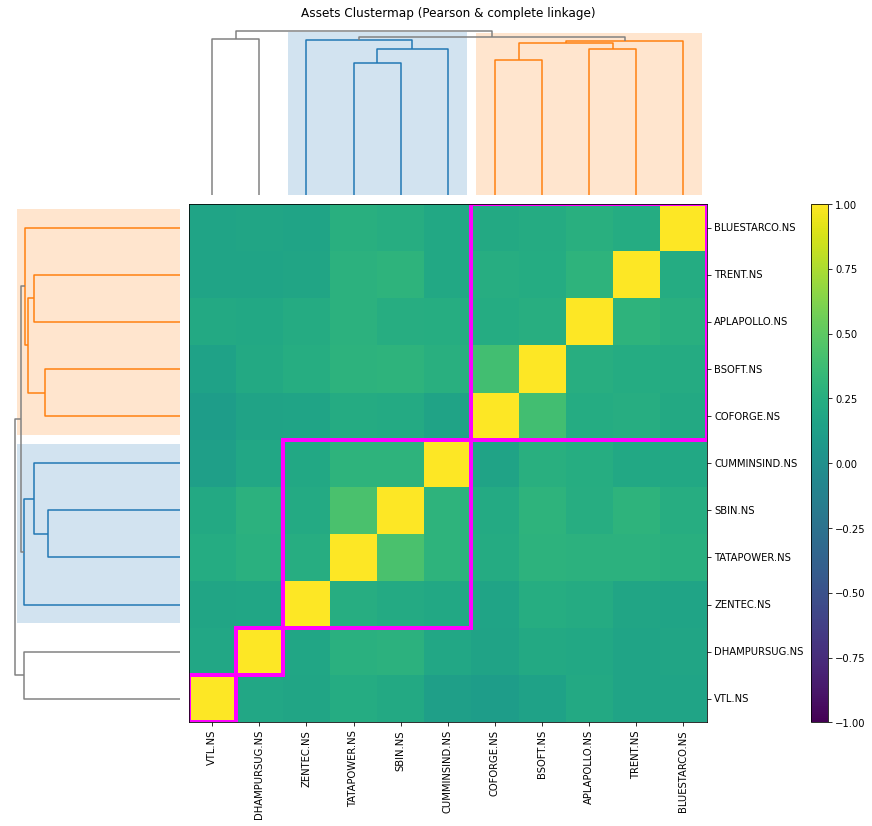

In [ ]:
ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      ax=None)

In [ ]:
# Building the portfolio object
port2 = rp.HCPortfolio(returns=Y)

In [ ]:
# Estimate optimal portfolio:

w2 = port2.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      hist=hist)

display(w2.T)

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
weights,0.059123,0.096849,0.044228,0.144569,0.042749,0.132009,0.069645,0.050808,0.139879,0.184734,0.035407


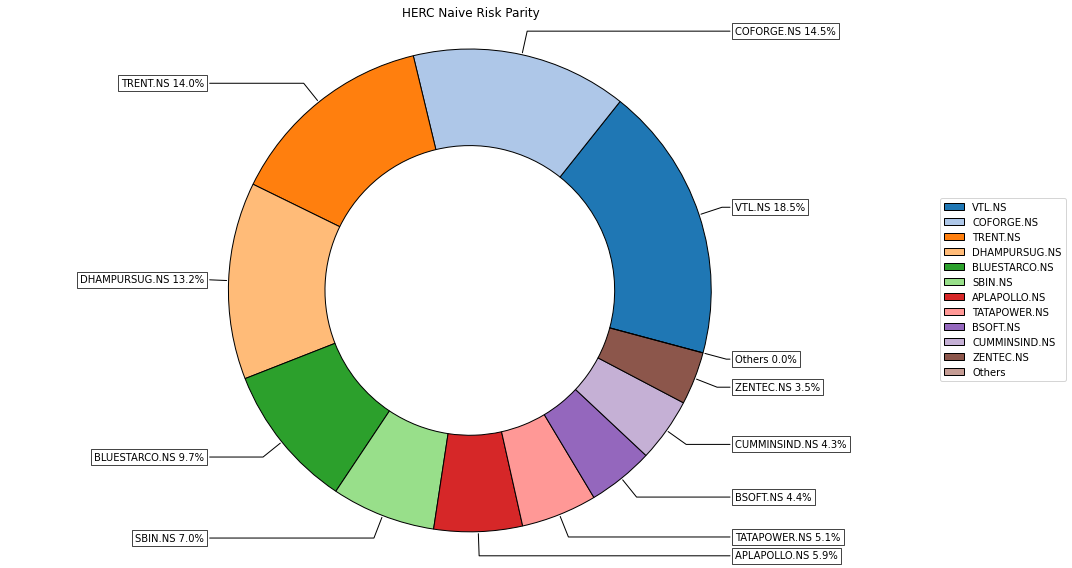

In [ ]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w2,
                 title='HERC Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

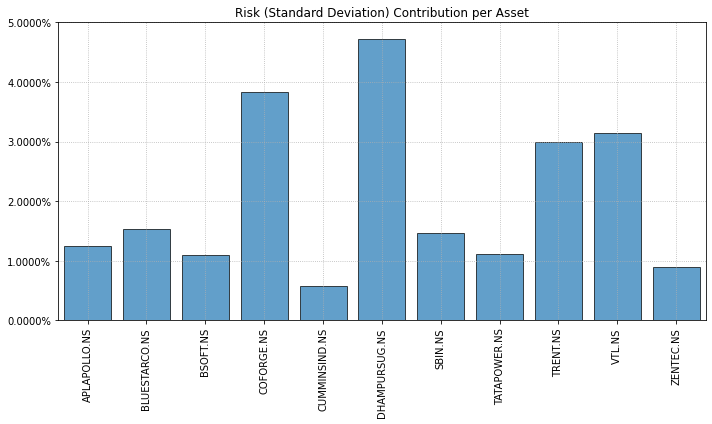

In [ ]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w2,
                 cov=port2.cov, 
                 returns=port2.returns, 
                 ax=None)

In [ ]:
erW2, cvW2, srW2 = get_port_stats(port2.returns, w2, port2.cov)

Expected Returns: 32.95%
Annual Volatility: 22.65%
Sharpe Ratio: 1.45


In [ ]:
# returns2 = get_port_overall_returns(port2.returns, w2)
# rp.RiskFunctions.CVaR_Hist(returns2)

# Comparsion of HRP, HERC and DL models

In [ ]:
comparison_models_len = 5

In [ ]:
pred_weights_1_index_changed = pred_weights_1.reset_index(drop = True)
pred_weights_1_index_changed = pred_weights_1_index_changed.set_index(w1.index)
pred_weights_1_index_changed = pred_weights_1_index_changed.rename({0: 'weights'}, axis=1)

# pred_weights_2_index_changed = pred_weights_2.reset_index(drop = True)
# pred_weights_2_index_changed = pred_weights_2_index_changed.set_index(w1.index)
# pred_weights_2_index_changed = pred_weights_2_index_changed.rename({0: 'weights'}, axis=1)

In [ ]:
compare_dl_w1_w2 = pd.concat([pred_weights_1_index_changed,
                              # pred_weights_2_index_changed, 
                              weightsdf1,
                              w1,
                              weightsdf2,
                              w2], 
                             keys=["DL Model Weights",
                                   # "DL Model Weights (Method 2)", 
                                   "HRP Weights (PyPortfolioOpt)",
                                   "HRP Weights (Riskfolio lib)",
                                   "CLA (PyPortfolioOpt)", 
                                   "HERC Weights (Riskfolio lib)"], 
                             axis= 1)

compare_dl_w1_w2

,DL Model Weights,HRP Weights (PyPortfolioOpt),HRP Weights (Riskfolio lib),CLA (PyPortfolioOpt),HERC Weights (Riskfolio lib)
,weights,weights,weights,weights,weights
APLAPOLLO.NS,0.012547,0.07555,0.071973,0.36543,0.059123
BLUESTARCO.NS,0.208215,0.16058,0.119905,0.00000,0.096849
BSOFT.NS,0.008587,0.06281,0.084166,0.06761,0.044228
COFORGE.NS,0.004966,0.07720,0.178985,0.34184,0.144569
CUMMINSIND.NS,0.577337,0.11475,0.037029,0.00000,0.042749
DHAMPURSUG.NS,0.009358,0.04249,0.067534,0.00000,0.132009
SBIN.NS,0.005996,0.06951,0.109931,0.00000,0.069645
TATAPOWER.NS,0.010548,0.06272,0.044009,0.01686,0.050808
TRENT.NS,0.007585,0.10267,0.170283,0.20827,0.139879


In [ ]:
def get_stats_df(er, cv, sr, col_name):
  stats_df = pd.DataFrame(np.array([er, cv, sr]).T, index=["Expected Returns", "Annual Volatility", "Sharpe Ratio"])
  stats_df = stats_df.rename({ 0: col_name }, axis = 1)
  
  return stats_df

In [ ]:
port_stats_dl1_dl2_w1_w2 = pd.concat([get_stats_df(erDLm1, cvDLm1, srDLm1, "DL Model"),
                                 # get_stats_df(erDL, cvDL, srDL, "DL Model (Method 2)"),
                                 get_stats_df(erW1Plib, cvW1Plib, srW1Plib, 
                                              "HRP (PyPortfolioOpt)"),
                                 get_stats_df(erW1, cvW1, srW1, "HRP (Riskfolio lib)"),
                                 get_stats_df(erW2Plib, cvW2Plib, srW2Plib, "CLA (PyPortfolioOpt)"),
                                 get_stats_df(erW2, cvW2, srW2, "HERC (Riskfolio lib)")], 
                                axis = 1)

port_stats_dl1_dl2_w1_w2

,DL Model,HRP (PyPortfolioOpt),HRP (Riskfolio lib),CLA (PyPortfolioOpt),HERC (Riskfolio lib)
Expected Returns,13.52,28.70,35.94,52.65,32.95
Annual Volatility,23.93,21.09,23.26,29.30,22.65
Sharpe Ratio,0.57,1.36,1.55,1.80,1.45


## Plotting Risk contribution of each asset for each method

In [ ]:
colors = ["blue", "red", "green", "yellow", "pink"]
weights_list = [pred_weights_1_index_changed, weightsdf1, w1, weightsdf2, w2] 
title_list = ["DL Model Weights",
            "HRP Weights (PyPortfolioOpt)",
            "HRP Weights (Riskfolio lib)",
            "CLA (PyPortfolioOpt)", 
            "HERC Weights (Riskfolio lib)"]

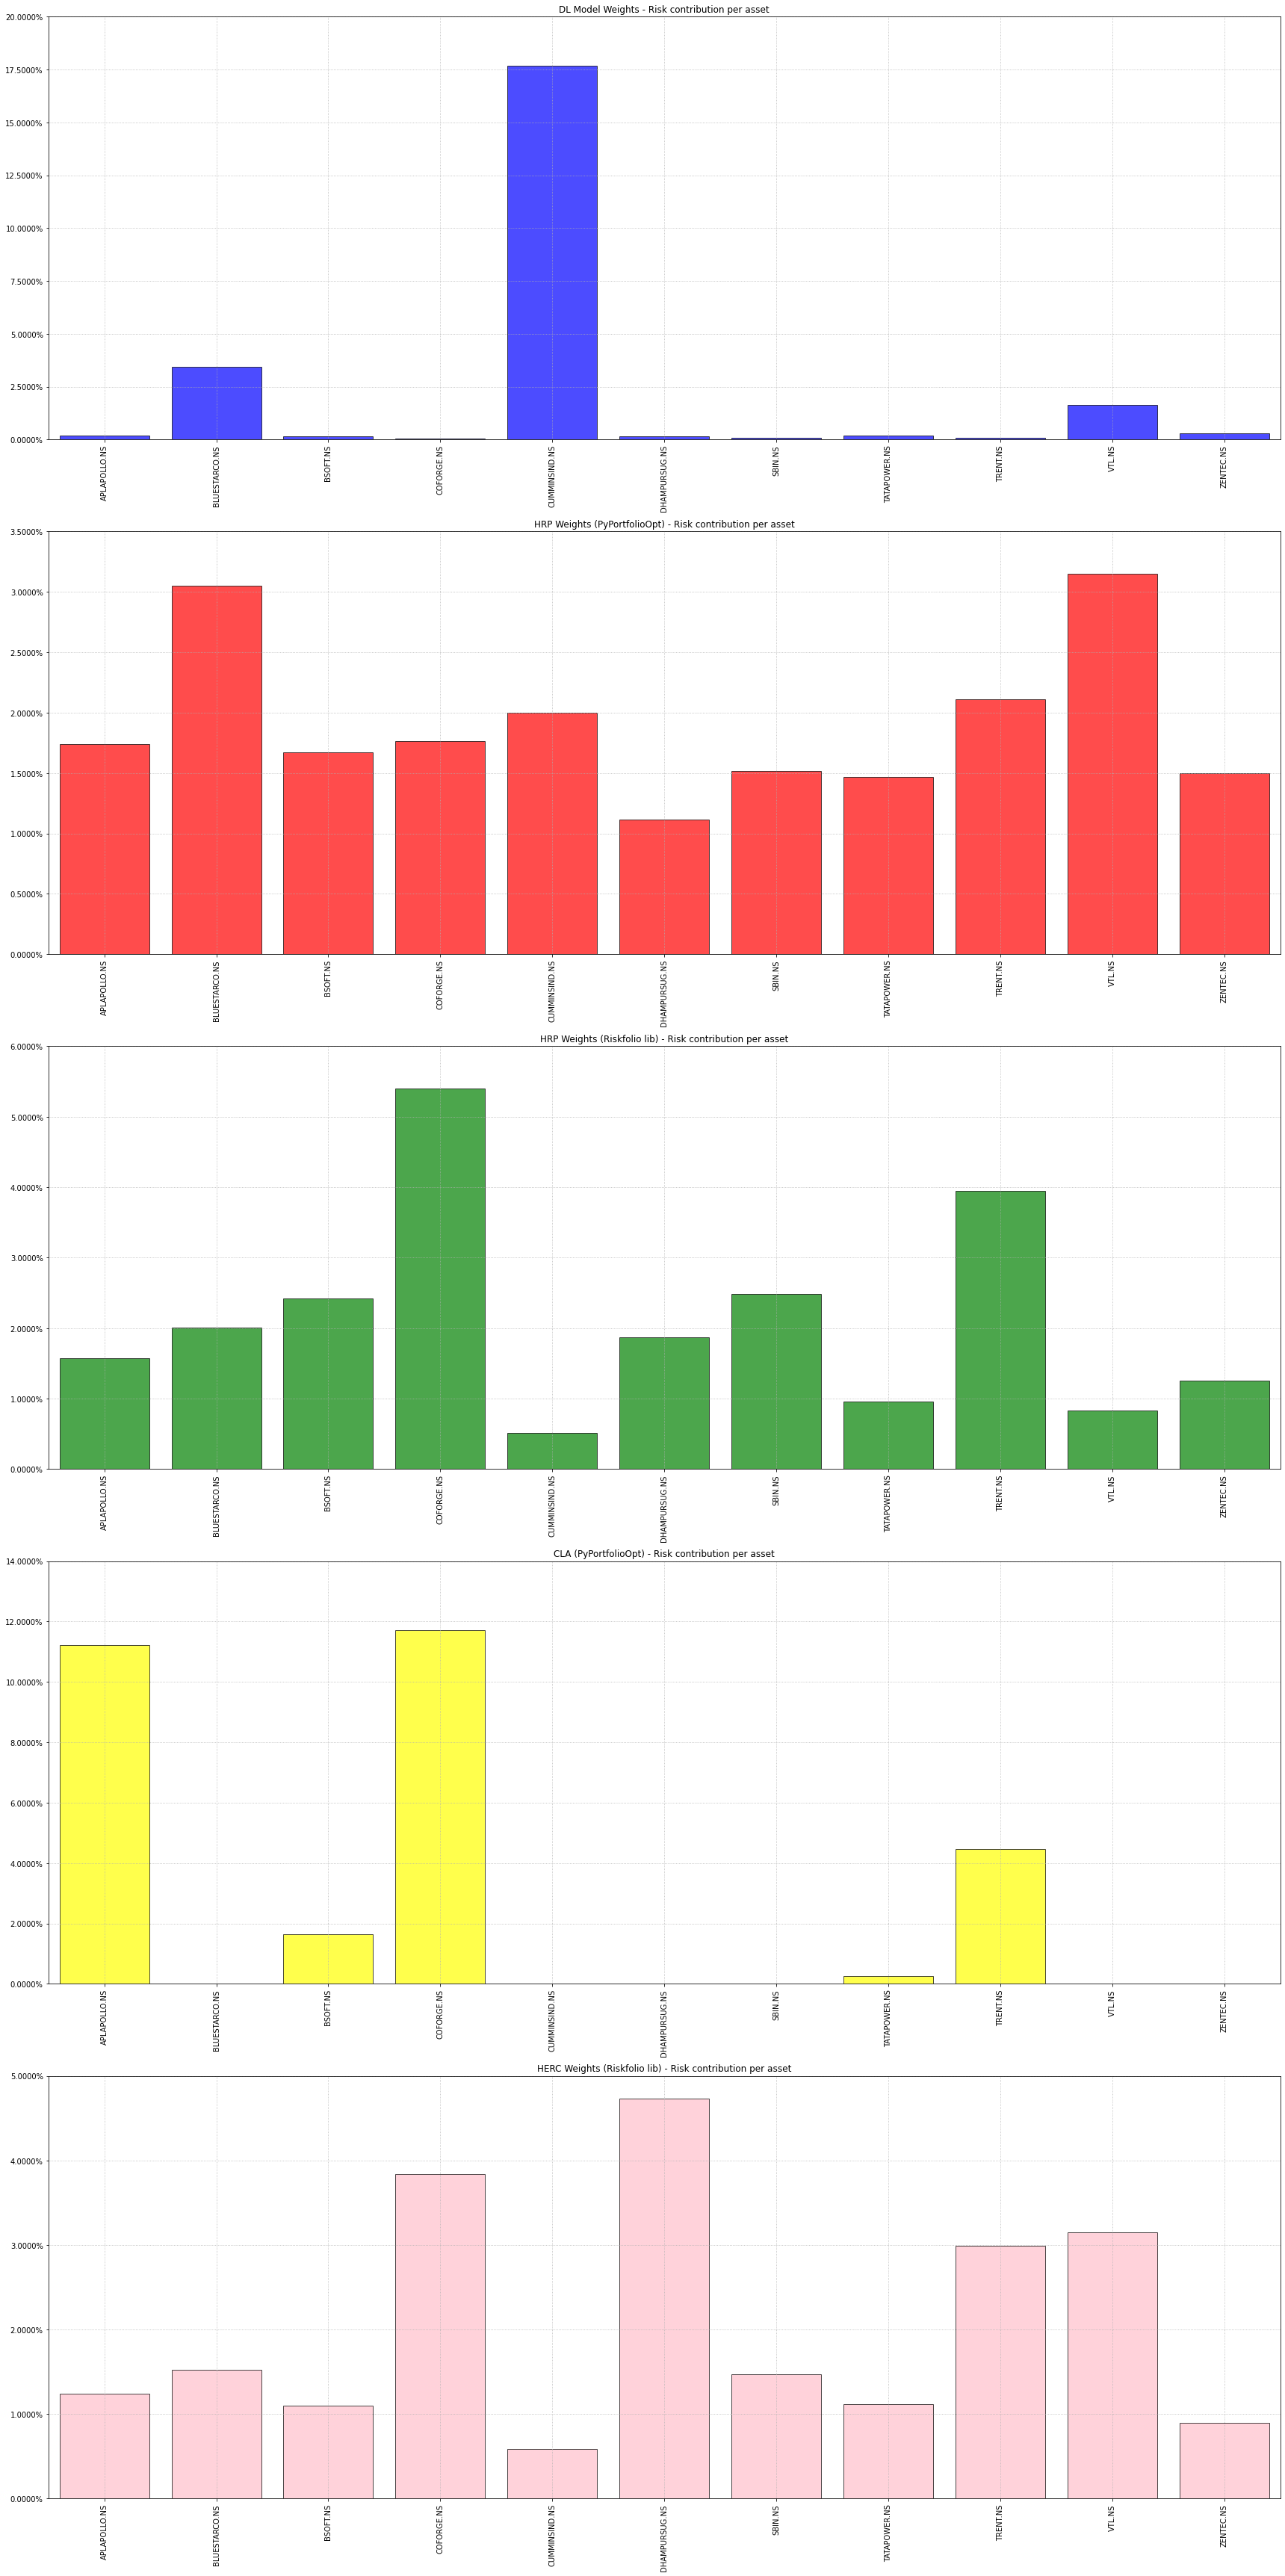

In [ ]:
# Plotting the risk contribution graph of each asset for each comparison method

figure, axis = plt.subplots(comparison_models_len, 1, figsize=(24,48), facecolor=(1, 1, 1)) # (rows, cols, figsize, facecolor)

for i in range(comparison_models_len):
  rp.plot_risk_con(w=weights_list[i],
                  cov=cov, 
                  color=colors[i],
                  returns=pct_change,
                  ax = axis[i])
  
  axis[i].set_title(title_list[i] + " - Risk contribution per asset")
